In [1]:
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import ma, cm
import seaborn as sns
import statsmodels.api as sm
import plot_config
from sklearn.metrics import cohen_kappa_score, accuracy_score
from imblearn.metrics import geometric_mean_score
plot_config.set_config()

/home/jader/Projects/meta_experiments/venv/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
experiment = 'elec2'
name_caps = 'Electricity'

In [3]:
off_scores = load('../data/'+experiment+'/off_scores.joblib')
off_preds = load('../data/'+experiment+'/off_preds.joblib')
off_targets = load('../data/'+experiment+'/off_targets.joblib')

In [4]:
kappas = []
gmeans = []
accurs = []
for i in range(100):
    scores = off_scores[300+i:300+i+10]
    app = [i for i,(x,y) in enumerate(scores) if abs(x-y)>0.1]
    preds = off_preds[i][app]
    targets = off_targets[i][app]
    
    if not np.isnan(geometric_mean_score(targets, preds)):
        gmeans.append(geometric_mean_score(targets, preds))
        
    if not np.isnan(accuracy_score(off_targets[i], off_preds[i])):
        accurs.append(accuracy_score(off_targets[i], off_preds[i]))
        
    if np.array_equal(preds, targets):
        kappas.append(1.0)
    else:
        kappas.append(cohen_kappa_score(targets, preds))
print(np.mean(kappas), "+-", np.std(kappas))
print(np.mean(gmeans), "+-", np.std(gmeans))
print(np.mean(accurs), "+-", np.std(accurs))

0.2504615384615384 +- 0.40427594224161445
0.24114860067583868 +- 0.3661723649825767
0.6096328588422242 +- 0.15242053250736187


/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/scipy/stats/stats.py:411: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


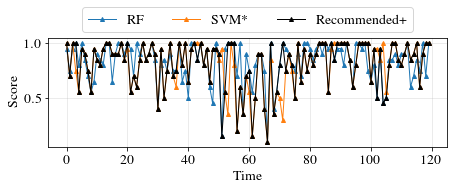

In [5]:
rf_score = load('../data/'+experiment+'/score_rf.joblib')[:120]
svm_score = load('../data/'+experiment+'/score_svm.joblib')[:120]
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))[:120]
fig = plt.gcf()
fig.set_size_inches(7.14, 2)
plt.plot(rf_score, '^-', label='RF')
plt.plot(svm_score, '^-', label='SVM*')
plt.plot(score_recommended, 'k^-', label='Recommended+')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True)
plt.savefig(experiment+'_tscores.pdf', bbox_inches='tight')

In [6]:
exps_fi = {}
for exp in ['elec2', 'covtype', 'powersupply']:
    t_importance = load('../data/'+exp+'/importance.joblib')
    t_fname = load('../data/'+exp+'/fnames.joblib')[:-1]
    exps_fi[exp] = dict(sorted(zip(t_fname,t_importance), key=lambda x: x[1], reverse=True)[:5])
    
#t_importance = load('../data/'+experiment+'/importance.joblib')
#t_fname = load('../data/'+experiment+'/fnames.joblib')[:-1]
    
#dic = sorted([(k,v) for k,v in zip(t_importance, t_fname)])[-5:]
#importance = [k for k,v in dic]
#fname = [v for k,v in dic]
pos = np.arange(4,-1,-1)

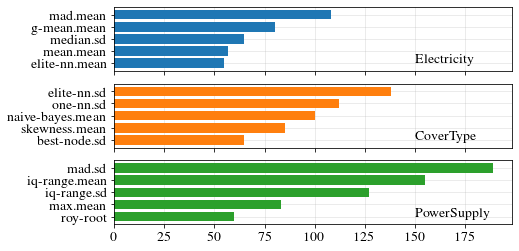

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
fe2 = exps_fi['elec2']
ax1.barh(pos, fe2.values(), align='center', tick_label=[x.replace('_','-') for x in fe2.keys()], label='Electricity')

ax1.text(150, 0, 'Electricity')

fct = exps_fi['covtype']
ax2.barh(pos, fct.values(), align='center', tick_label=[x.replace('_','-') for x in fct.keys()], color='C1',
         label='CoverType')
ax2.text(150, 0, 'CoverType')

fps = exps_fi['powersupply']
ax3.barh(pos, fps.values(), align='center', tick_label=[x.replace('_','-') for x in fps.keys()], color='C2',
        label='PowerSupply')
ax3.text(150, 0, 'PowerSupply')

fig.set_size_inches(7.14, 4)
plt.savefig('general_fi.pdf', bbox_inches='tight')

In [8]:
translate = {'elec2':'Electricity', 'covtype':'CoverType', 'powersupply':'PowerSupply'}

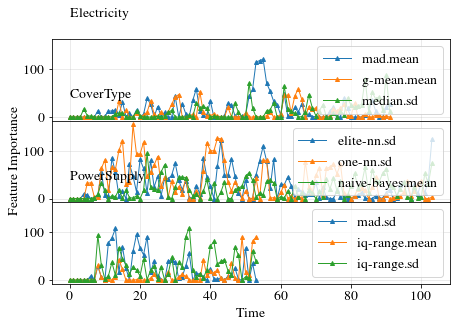

In [9]:
fig, ax = plt.subplots(3, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

for i, exp in enumerate(['elec2', 'covtype', 'powersupply']):
    tfi = load('../data/'+exp+'_ninc/tfi.joblib')[:150]
    topfname = list(exps_fi[exp].keys())[:3]
    t_fname = load('../data/'+exp+'/fnames.joblib')[:-1]
    tfi = pd.DataFrame(tfi, columns=t_fname)[topfname]
    tfi.rename(columns={x:x.replace('_','-') for x in topfname}, inplace=True)
    ax[1].set_ylabel('Feature Importance')
    ax[i].text(0, 210, translate[exp])
    for cols in tfi.iteritems():
        ax[i].plot(cols[1], '^-', label=cols[0])
        ax[i].legend(loc='right')

fig.set_size_inches(7.14, 4.5)
plt.xlabel('Time')
plt.savefig('general_timefi.pdf', bbox_inches='tight')

In [10]:
arange = 500
difference = np.array(load('../data/'+experiment+'/difference.joblib'))
difference_ninc = np.array(load('../data/'+experiment+'_ninc/difference.joblib'))
cum = np.cumsum(difference)[:arange]
cum_ninc = np.cumsum(difference_ninc)[:arange]
x = np.arange(arange)

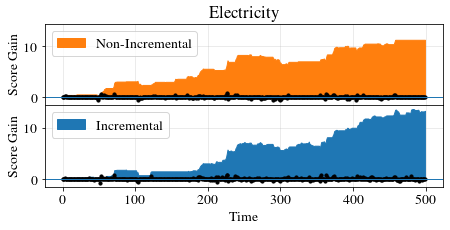

In [11]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0})

ax1.fill_between(x, cum_ninc, 0, color='C1', label='Non-Incremental')
ax1.scatter(x, difference_ninc[:arange], s=10, c='black')
ax1.set_title(name_caps)
ax1.axhline(0)
ax1.legend(loc='upper left')
ax1.set_ylabel('Score Gain')

ax2.fill_between(x, cum, 0, color='C0', label='Incremental')
ax2.scatter(x, difference[:arange], s=10, c='black')
ax2.axhline(0)
ax2.legend(loc='upper left')
ax2.set_ylabel('Score Gain')
ax2.set_xlabel('Time')

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_cumsum.pdf', bbox_inches='tight')

In [12]:
print(cum[-10:])

[13.5  13.1  13.05 13.15 13.25 13.15 13.2  13.15 13.2  13.3 ]


In [13]:
mbest = np.array(load('../data/'+experiment+'/best.joblib'))
mrecommended = np.array(load('../data/'+experiment+'/recommended.joblib'))
msvm = np.array(load('../data/'+experiment+'/score_svm.joblib'))
mrf = np.array(load('../data/'+experiment+'/score_rf.joblib'))

In [14]:
print('incremental')
filtered = np.abs(msvm-mrf) > .1
print(cohen_kappa_score(mbest[filtered], mrecommended[filtered]))
print(geometric_mean_score(mbest[filtered], mrecommended[filtered]))

incremental
0.024234355579362377
0.3947989848367301


In [15]:
mbest = np.array(load('../data/'+experiment+'_ninc/best.joblib'))
mrecommended = np.array(load('../data/'+experiment+'_ninc/recommended.joblib'))
msvm = np.array(load('../data/'+experiment+'_ninc/score_svm.joblib'))
mrf = np.array(load('../data/'+experiment+'_ninc/score_rf.joblib'))

In [16]:
print('non incremental')
filtered = np.abs(msvm-mrf) > .1
print(cohen_kappa_score(mbest[filtered], mrecommended[filtered]))
print(geometric_mean_score(mbest[filtered], mrecommended[filtered]))

non incremental
0.01853009906855807
0.47327732778324133


In [17]:
metadf = load('../data/'+experiment+'/metadf.joblib')
best = np.array(load('../data/'+experiment+'/best.joblib'))
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))
score_default = np.array(load('../data/'+experiment+'/score_def.joblib'))


score_recommended_ninc = np.array(load('../data/'+experiment+'_ninc/score_reco.joblib'))
score_default_ninc = np.array(load('../data/'+experiment+'_ninc/score_def.joblib'))

/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Spectral"))
  import sys
/home/jader/Projects/meta_experiments/venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Spectral"))


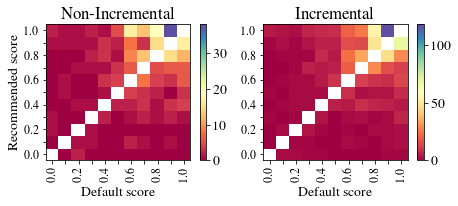

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(bottom=0.25)

heatmap, xedges, yedges = np.histogram2d(score_default_ninc, score_recommended_ninc, bins=11)
mask = np.diag(np.ones(11))
masked_data = ma.masked_array(heatmap.T, mask)
cm.Spectral.set_bad(color='white', alpha=None)
im1 = ax1.pcolormesh(masked_data, cmap=cm.Spectral)
ax1.set_ylabel('Recommended score')
ax1.set_title('Non-Incremental')
ax1.set_xlabel('Default score')
ticks = ["{:.1f}".format(x) for x in np.linspace(0,1,11)]
ticksl = ["{:.1f}".format(x) if int(x*10)%2==0 else "" for x in np.linspace(0,1,11)]
ax1.set_xticks(np.arange(len(ticks))+.5, minor=False)
ax1.set_yticks(np.arange(len(ticks))+.5, minor=False)
ax1.set_xticklabels(ticksl, rotation=90, fontdict={'fontsize':12})
ax1.set_yticklabels(ticksl, fontdict={'fontsize':12})
ax1.figure.colorbar(im1, ax=ax1)


heatmap, xedges, yedges = np.histogram2d(score_default, score_recommended, bins=11)
mask = np.diag(np.ones(11))
masked_data = ma.masked_array(heatmap.T, mask)
cm.Spectral.set_bad(color='white', alpha=None)
im2 = ax2.pcolormesh(masked_data, cmap=cm.Spectral)
ax2.set_title('Incremental')
ax2.set_xlabel('Default score')
ticks = ["{:.1f}".format(x) for x in np.linspace(0,1,11)]
ticksl = ["{:.1f}".format(x) if int(x*10)%2==0 else "" for x in np.linspace(0,1,11)]
ax2.set_xticks(np.arange(len(ticks))+.5, minor=False)
ax2.set_yticks(np.arange(len(ticks))+.5, minor=False)
ax2.set_xticklabels(ticksl, rotation=90, fontdict={'fontsize':12})
ax2.set_yticklabels(ticksl, fontdict={'fontsize':12})
ax2.figure.colorbar(im2, ax=ax2)

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_score.pdf')